## **Content**

* [**About the Competition**](#1)
    * Objective of the Competition
    * About the kernel
    * Key TakeAways
* [**Importing the necessary Packages**](#2)
* [**Initial Data preparation**](#3)
* [**Exploratory Data Analysis**](#4)
    * Stadium and Match Analysis
    * Player Analysis
    * Objective Anaysis
* [**Feature Engineering**](#5)
    * Feature Generalization
    * Feature Creation  
    * Missing Value Imputation
    * Label Encoding
* [**What are we predicting?**](#6)
    * Detailed Explanation
    * How cummulative distribution works?
   

 



## About the Competition <a id="1"></a>

![Alt_Text](https://media.giphy.com/media/Qe6qalKCHM5Da/giphy.gif)




The dataset of the competition contains Next Gen Stats tracking data for running plays we will predict how many yards a team will gain on a rushing play in an NFL regular season game.We have to loop through a series of rushing plays; for each play, you'll receive the position, velocity, orientation, and more for all 22 players on the field at the moment of handing the ball off to the rusher, along with many other features such as teams, stadium, weather conditions, etc.We'll have to use this information to predict how many yards the team will gain on the play as a cumulative probability distribution. Once we make that prediction, we can move on to the next rushing play.

**About this kernel**

This kernel will acts as a guide covering the A-Z topics on this data 

If you don't know how the American football works I would highly recommend you to visit this [discussion](https://www.kaggle.com/c/nfl-big-data-bowl-2020/discussion/111945#latest-651107)

**Key Takeaway's**

* Extensive EDA
* Understanding the nature of NFL
* Effective Story Telling
* Creative Feature Engineering
* Modelling
* Ensembling

**The plots made are interactive one's feel free to hover over**

## Importing the necessary Packages <a id="2"></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from plotly.offline import iplot
from plotly import tools
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.preprocessing import LabelEncoder


## Initial Data Preparation <a id="3"></a>

In [ ]:

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
df= pd.read_csv('../input/nfl-big-data-bowl-2020/train.csv', low_memory=False)

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df.isnull().sum()

We can clearly see there are few missing values present in the data we'll try to explore the data try find if there are any relation to impute the missing data

**Reading the test data**

In [ ]:
from kaggle.competitions import nflrush

# You can only call make_env() once, so don't lose it!
env = nflrush.make_env()

# You can only iterate through a result from `env.iter_test()` once
# so be careful not to lose it once you start iterating.
iter_test = env.iter_test()

(test_df, sample_prediction_df) = next(iter_test)
#test_df

In [ ]:
test_df.head()

## Exploratory Data Analysis <a id="4"></a>

## Stadium and Matches Analysis

**Stadium** based on Location


**Location** provided contains City as well as State of the city so I am trying to seperate those city and state into two columns 

In [ ]:
state_dictionary={'Huston':'Texas', 'Mexico City':'Mexico','Jacksonville':'Florida','Baltimore':'Maryland',
                  'Landover':'Maryland', 'New Orleans':'Louisiana','Orchard Park' : 'New York',
                  'Cleveland':'Ohio','Tampa':'Florida','Carson': 'California', 'Charlotte':'North Carolina',
                  'Minneapolis':'Minnesota','Detroit':'Michigan', 'Houston':'Texas', 'Chicago':'Illinois',
                  'Nashville':'Tennessee','Miami Gardens':'Florida', 'E. Rutherford': 'New Jersey',   
                  'Pittsburgh':'Pennsylvania', 'Arlington':'Texas', 'Baltimore': 'Maryland', 
                  'New Orleans':'Louisiana','Atlanta':'Georgia', 'Jacksonville': 'Florida',
                  'New Orleans': 'Louisiana', 'Seattle':'Washington', 'East Rutherford':'New Jersey', 
                  'Cincinnati':'Ohio', 'Foxborough':'Massachusetts','Oakland': 'California',
                  'Arlington':'Texas', 'Glendale': 'Arizona', 'Pittsburgh':' Kansas', 'London':'England',
                  'Orchard Park': 'New York','Philadelphia': 'Pennsylvania', 'Kansas City':'Missouri',
                  'Los Angeles':'California', 'Santa Clara':'California','Jacksonville':'Florida',
                  'East Rutherford': 'New Jersey','Indianapolis':'Indiana', 'Green Bay':'Wisconsin', 
                  'Denver':'Colorado','Charlotte': 'North Carolina','Tampa':'Florida',
                   'Chicago. IL':'Illinois', 'Cleveland Ohio':'Ohio', 'Jacksonville Florida':'Florida', 'Orchard Park NY':'New York'}

In [ ]:
Location=[]
for i in df.Location:
    try:
        Location.append(i.split(',')[0])
    except:
         Location.append(i.split(' '))[0]

In [ ]:
df['Location']=Location
df['State']=df['Location'].map(state_dictionary)

**Finding the number of teams from Each state**

In [ ]:
temp=df.drop_duplicates('HomeTeamAbbr', keep='last')['State']
Code=['CA','FL','TX','OH','NJ','MD','GA','MA','WI','AZ','NC','PA','WA','KS','MO','IN','IL','NY',
     'TN','MI','MN','CO','LA']
Teams_from_state=pd.DataFrame()
Teams_from_state['Sate']=temp.value_counts().index
Teams_from_state['Count']=temp.value_counts().values
Teams_from_state['Code']=Code

In [ ]:
fig = go.Figure(data=go.Choropleth(
    locations=Teams_from_state['Code'], # Spatial coordinates
    z = Teams_from_state['Count'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Teams per State",
))

fig.update_layout(
    title_text = 'Teams from each state of USA in NFL',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

**Observations**

From this we can clearly see that **California** has the maximum number of teams in **NFL**


**Data available based on season**

In [ ]:
df['Dummy']=[1]*len(df) #Adding a dummy column for future use

In [ ]:
temp=df.drop_duplicates('GameId', keep='last')
temp_df = temp.groupby(["Season"])["Dummy"].agg(["sum"]).reset_index()
temp_df.columns = ["Season","TotalGames"]
fig = go.Figure(data=[go.Pie(labels=temp_df['Season'], values=temp_df['TotalGames'],hole=0.2)])
fig.show()

**Matches Weekly basis**

In [ ]:
temp=df.drop_duplicates('GameId', keep='last')['Week']
Matches_on_weekly_basis=pd.DataFrame()
Matches_on_weekly_basis['Week']=temp.value_counts().index
Matches_on_weekly_basis['Count']=temp.value_counts().values
Matches_on_weekly_basis=Matches_on_weekly_basis.sort_values(by='Week')
fig = px.line(Matches_on_weekly_basis, x="Week", y="Count", title='Matches on Weekly Basis')
fig.show()

**Observations:**

* Minimum Number of Matches conducted in a week is 26 and in week 9

* Maximum Number of Matches conducted in a week is 32 and in week 2 and 13-16

**Different Types of Stadium present in the NFL **

In [ ]:
Type_map={'Outdoor':'Outdoor','Outdoors':'Outdoor','Oudoor':'Outdoor'
         ,'Ourdoor':'Outdoor','Outside':'Outdoor','Outdor':'Outdoor'
         ,'Outddors':'Outdoor','Retractable Roof':'Retractable Roof',
         'Retr. Roof-Closed':'Retractable Roof','Retr. Roof - Closed':'Retractable Roof',
         'Retr. Roof Closed':'Retractable Roof',  "Outdoor Retr Roof-Open":"Outdoor",
         "Indoors":"Indoor","Indoor":"Indoor","Indoor, Roof Closed":"Indoor",
         "Doom":"Doom","Domed, closed":"Doom","Domed, open":"Doom","Closed Dome":"Doom"
         ,"Bowl":"Bowl","Open":"Outdoor","Cloudy":"Outdoor","Domed, Open":"Doom"
         ,'Retr. Roof-Open':'Retractable Roof',"Retr. Roof - Open":"Retractable Roof",
          "Indoor, Open Roof":"Indoor","Heinz Field" :"Heinz Field"}

In [ ]:
df.StadiumType=df.StadiumType.map(Type_map)
Stadium=pd.DataFrame()
Stadium['Type']=df.StadiumType.value_counts().index
Stadium['Count']=df.StadiumType.value_counts().values


In [ ]:
import plotly.offline as pyo
py.init_notebook_mode(connected=True)
fig = go.Figure(data=[go.Pie(labels=Stadium['Type'], values=Stadium['Count'],hole=0.2)])
fig.show()

**Different types of turfs in Different types of Stadium**

In [ ]:
df['Turf'].unique()

Turf_map={"Grass":"Grass","grass":"Grass",'Twenty-Four/Seven Turf':"FieldTurf",
          'DD GrassMaster':'DD GrassMaster','A-Turf Titan':'A-Turf Titan',
          "FieldTurf 360":"FieldTurf","FieldTurf360":"FieldTurf",'UBU Sports Speed S5-M':'UBU Sports Speed S5-M',
         "Field Turf":"FieldTurf","Natural":"Natural", "Natural Grass":"Natural",
         "Natural grass":"Natural","Naturall Grass":"Natural",'SISGrass':'Grass',
          'UBU Speed Series-S5-M':"UBU Speed Series-S5-M","Artifical":"Artifical","Artificial":"Artifical"}

In [ ]:
df.Turf=df.Turf.map(Turf_map)
temp=df.groupby(['StadiumType','Turf']).agg('count')['Dummy']

In [ ]:
temp.unstack(level=0).plot(kind='bar', subplots=True,figsize=(10,10))

**Matches Distribution on Stadium Types on Weekly Basis**

In [ ]:
temp=df.drop_duplicates('GameId', keep='last')
temp_df = df.groupby(["Week","StadiumType"])["StadiumType"].agg(["count"]).reset_index()
temp_df.columns = ["Week","StadiumType", "Count"]
#temp_df.Country = temp_df[temp_df.Country != 'United Kingdom']

fig = px.scatter(temp_df, x="Week", y="StadiumType", color="StadiumType", size="Count")
layout = go.Layout(
    title=go.layout.Title(
        text="Matches played in different Stadium Types on each week",
        x=0.5
    ),
    font=dict(size=14),
    width=800,
    height=600,
    showlegend=False
)
fig.update_layout(layout)
fig.show()

**Weather of the game over the week's in NFL**

In [ ]:
temp=df.drop_duplicates('GameId', keep='last')
temp_df = df.groupby(["Week","GameWeather"])["GameWeather"].agg(["count"]).reset_index()
temp_df.columns = ["Week","GameWeather", "Count"]


fig = px.scatter(temp_df, x="Week", y="GameWeather", color="GameWeather", size="Count")
layout = go.Layout(
    title=go.layout.Title(
        text="Game weather on each week",
        x=0.5
    ),
    font=dict(size=14),
    width=800,
    height=600,
    showlegend=False
)
fig.update_layout(layout)
fig.show()

**Wind Direction Vs Wind Speed on season 2017**

In [ ]:
temp_df=df.loc[df.Season==2017]
temp_df=temp_df.drop_duplicates('GameId', keep='last')
temp_df=temp_df[["WindSpeed","WindDirection"]]
temp_df=temp_df.dropna()
fig = px.bar_polar(temp_df, r="WindSpeed", theta="WindDirection",
                   color="WindSpeed", template="plotly_dark",
                   color_discrete_sequence= px.colors.sequential.Plasma[-2::-1])
fig.show()

**Wind Direction VS Wind Speed on season 2018**

In [ ]:
temp_df=df.loc[df.Season==2018]
temp_df=temp_df.drop_duplicates('GameId', keep='last')
temp_df=temp_df[["WindSpeed","WindDirection"]]
temp_df=temp_df.dropna()
fig = px.bar_polar(temp_df, r="WindSpeed", theta="WindDirection",
                   color="WindSpeed", template="plotly_dark",
                   color_discrete_sequence= px.colors.sequential.Plasma[-2::-1])
fig.show()

## **Player's Analysis**

**Player's Position Analysis**

In [ ]:
temp=df.drop_duplicates('PlayId', keep='last')['Position']
Player_Analysis=pd.DataFrame()
Player_Analysis['Position']=temp.value_counts().index
Player_Analysis['Count']=temp.value_counts().values

fig = px.bar(Player_Analysis, x='Position', y='Count',
             hover_data=['Count'], color='Count',
             labels={'pop':'Total Number of Players on each position'}, height=400)
fig.show()

**Player Position and Meaning**

**WR** -A **wide receiver**, also referred to as wideouts or simply receivers, is an offensive position in American and Canadian football, and is a **key player**.

**CB**-A **cornerback**, also referred to as a corner or defensive halfback in older parlance, is a member of the defensive backfield or secondary in American and Canadian football.

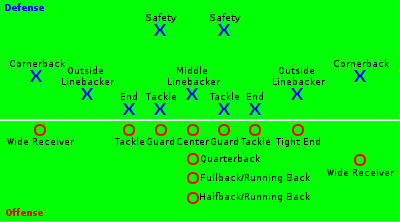


Source:[Wikipedia](https://en.wikipedia.org/wiki/American_football_positions)

To have a more clear understanding please visit the source

**Player weight's Distribution across NFL**

Since player's participating in a sport tend to be in a particular Figure and since the data is very huge we'll take data for particular team and find the distribtuion since it might represent whole set of NFL players

In [ ]:
# Add histogram data
x1 =df.loc[df.HomeTeamAbbr=='LA']['PlayerWeight']
# Group data together
hist_data = [x1]

group_labels = ['PlayerWeight']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.2)
fig.show()

**Height Distribution across NFL Players**

For our convenience we'll convert the height into centimeter's

In [ ]:
from operator import add
foot=[int(ht[0]) for ht in df.PlayerHeight.str.split('-')]
inches=[int(ht[1]) for ht in df.PlayerHeight.str.split('-')]
height=list(map(add,[x*30.48 for x in foot],[x*2.54 for x in inches]))
df.PlayerHeight=height

In [ ]:
import plotly.figure_factory as ff
import numpy as np


# Add histogram data
x1 =df.loc[df.HomeTeamAbbr=='LA']['PlayerHeight']
# Group data together
hist_data = [x1]

group_labels = ['PlayerHeight']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.2)
fig.show()

**Players from Most College**

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

inv_names = []
for invs in df['PlayerCollegeName']:
    for inv in str(invs).split():
        if inv != "":
            inv_names.append(inv.strip().lower().replace("'",""))
            
def plot_wordcloud(text, mask=None, max_words=40, max_font_size=80, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown', 'nan', ' nan'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    prefer_horizontal = 1.0,
                    max_font_size = max_font_size, 
                    min_font_size = 10,
                    random_state = 42,
                    #color_func = lambda *args, **kwargs: (140,0,0),
                    #color_func = color_map(),
                    colormap="Blues",
                    width=600, 
                    height=300,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        #image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_color), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size, 'color': 'blue',
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'blue', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

plot_wordcloud(' '.join(inv_names), title="Player's College Name")

The observation's and the plots made above are general. Now, let's get into the analysis of the **Objective** of the Competition

**Objective the Competition**

In the National Football League (NFL), roughly a third of teams’ offensive yardage comes from run plays. A running play or rushing play is a tactic in which the football is advanced up the field by a player running it rather than passing it. Competition is to develop a model to predict how many yards a team will gain on given rushing plays as they happen. We are given the data when the ball is handed off (TimeHandoff) to forecast the yardage gained on that play.

To create the visulaization of the NFL ground this amazing [kernel](https://www.kaggle.com/robikscube/nfl-big-data-bowl-plotting-player-position) has been refernced

In [ ]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

create_football_field()
plt.show()

## **Player's movement along the field Home vs Away**

**Home Team**

In [ ]:
fig, ax = create_football_field()
temp_df=df.loc[df["Team"]=="home"]
temp_df=temp_df[['X','Y']]

plt.hist2d(temp_df["X"],temp_df["Y"])
plt.colorbar()
plt.title("Home Players movement Along the field ")
fig.tight_layout()
plt.show()

**Away Team**

In [ ]:
fig, ax = create_football_field()
temp_df=df.loc[df["Team"]=="away"]
temp_df=temp_df[['X','Y']]

plt.hist2d(temp_df["X"],temp_df["Y"])
plt.colorbar()
plt.title("Away Players movement Along the field ")
fig.tight_layout()
plt.show()

**Observation**

Home Team is dominating on comparing the plots

## **Player's movement along the field in Quaterwise**

**Quater 1**

In [ ]:
fig, ax = create_football_field()
temp_df=df.loc[df["Quarter"]==1]
temp_df=temp_df[['X','Y']]

plt.hist2d(temp_df["X"],temp_df["Y"])
plt.colorbar()
plt.title("Players movement Along the field in Quater -1")
fig.tight_layout()
plt.show()

**Quater 2**

In [ ]:
fig, ax = create_football_field()
temp_df=df.loc[df["Quarter"]==2]
temp_df=temp_df[['X','Y']]

plt.hist2d(temp_df["X"],temp_df["Y"])
plt.colorbar()
plt.title("Players movement Along the field in Quater -2")
fig.tight_layout()
plt.show()

**Quater 3**

In [ ]:
fig, ax = create_football_field()
temp_df=df.loc[df["Quarter"]==3]
temp_df=temp_df[['X','Y']]

plt.hist2d(temp_df["X"],temp_df["Y"])
plt.colorbar()
plt.title("Players movement Along the field in Quater -3")
fig.tight_layout()
plt.show()

**Quater 4**

In [ ]:
fig, ax = create_football_field()
temp_df=df.loc[df["Quarter"]==4]
temp_df=temp_df[['X','Y']]

plt.hist2d(temp_df["X"],temp_df["Y"])
plt.colorbar()
plt.title("Players movement Along the field in Quater -4")
fig.tight_layout()
plt.show()

**Quater 5**

In [ ]:
fig, ax = create_football_field()
temp_df=df.loc[df["Quarter"]==5]
temp_df=temp_df[['X','Y']]

plt.hist2d(temp_df["X"],temp_df["Y"])
plt.colorbar()
plt.title("Players movement Along the field in Quater -5")
fig.tight_layout()
plt.show()

**Observations**

* Players movements in **Quaters 1,3,4** are almost same

* Players movements in **Quater 2** is little low
 
* Players movements in **Quater 5** is very low ---> Over Time

## Ball Possesion **Home Vs Away**

In [ ]:
temp=df.loc[df["HomeTeamAbbr"]==df["PossessionTeam"]]
Ball_Possession=pd.DataFrame()
Ball_Possession["Team"]=["Home","Away"]
Ball_Possession['Percent']=[len(temp)/len(df)*100,(100-len(temp)/len(df)*100)]

import plotly.offline as pyo
#py.init_notebook_mode(connected=True)
fig = go.Figure(data=[go.Pie(labels=Ball_Possession["Team"], values=Ball_Possession['Percent'],hole=0.2)])
fig.show()

## Speed Vs Acceleration

- Speed is the **distance covered** in a unit of time while acceleration is the **rate of change of speed**

In [ ]:
temp_df=df.loc[df["NflIdRusher"] == df["NflId"]]
fig = px.scatter(temp_df, x="S", y="A")
fig.update_layout(title="Speed VS Yards")
fig.show()

## Speed Vs Yards

In [ ]:
#fig, ax = create_football_field()
temp_df=df.loc[df["NflIdRusher"] == df["NflId"]]
fig=px.scatter(temp_df, x="S", y="Yards")
fig.update_layout(title="Speed VS Yards")
fig.show()

## Feature Engineering <a id="5"></a>

## Feature Generalization

**StadiumType**

StadiumType which is usually about whether the stadium is **indoor** or **outdoor**

The stadium Type provided contains names in different formats all of them had been generalised into a common format in the EDA section above

In [ ]:
test_df.StadiumType=test_df.StadiumType.map(Type_map)

**Turf**

Turf here represents the nature of the field wether the stadium has grass or natural field which is again been represented in different formats and has been normalized

In [ ]:
test_df.Turf=test_df.Turf.map(Turf_map)

**Direction of the wind**

Which can genrally be the 8 different but those have given in different formats which will be generalized over here


In [ ]:
WindMap={'SW':"SW", 'NNE':"NE", 'SE':"SE",'East':"E", np.nan:np.nan, 'NE':"NE", 'North':"N", 'S':"S", 'Northwest':"NW",
       'SouthWest':"SW", 'ENE':"NE", 'ESE':"SE", 'SSW':"SW", 'NW':"NW", 'Northeast':"NE", 'From S':"S", 'W':"W",
       'South':"S", 'West-Southwest':"SW", 'E':"E", '13':'13','N':"N", 'NNW':"NW",
       'South Southeast':"SE", 'SSE':"SE", 'West':"W", 'WSW':"SW", 'From SW':"SW", 'WNW':"NW", 's':"S",
       'NorthEast':"NE", 'from W':"W", 'W-NW':"NW", 'South Southwest':"SW", 'Southeast':"SE",
       'From WSW':"SW", 'West Northwest':"NW", 'Calm':"Calm", 'From SSE':"SE", 'From W':"W",
       'East North East':"NE", 'From ESE':"SE", 'EAST':"E", 'East Southeast':"SE",
       'From SSW':"SW", '8':"8", 'North East':"NE", 'Southwest':"SW", 'North/Northwest':"NW",
       'From NNE':"NE", '1':"NE", 'N-NE':"NE", 'W-SW':"SW", 'From NNW':"NW"}

In [ ]:
df.WindDirection=df.WindDirection.map(WindMap)
test_df.WindDirection=test_df.WindDirection.map(WindMap)

**Heigth**

Converting feet to cm

In [ ]:
#from operator import add
#foot=[int(ht[0]) for ht in test_df.PlayerHeight.str.split('-')]
#inches=[int(ht[1]) for ht in test_df.PlayerHeight.str.split('-')]
#height=list(map(add,[x*30.48 for x in foot],[x*2.54 for x in inches]))
#test_df.PlayerHeight=height

## Feature Creation

**State and City** are given as a single variable so I'm splitting into two variables

In [ ]:
Location=[]
for i in test_df.Location:
    try:
        Location.append(i.split(',')[0])
    except:
         Location.append(i.split(' '))[0]
test_df['Location']=Location
test_df['State']=df['Location'].map(state_dictionary)

## Missing value imputation

**StadiumType** It can be filled using the Home Team Info

In [ ]:
df['StadiumType']=df.groupby('HomeTeamAbbr')['StadiumType'].transform(lambda x: (x.fillna(x.mode())))

**WindSpeed** and **WindDirection** can be filled using Location, Time, Weather and weak of the play

In [ ]:
df['WindSpeed']=df.groupby(['Week','GameId'])['WindSpeed'].transform(lambda x: x.fillna(x.mode()))
df['WindDirection']=df.groupby(['Week','GameId'])['WindDirection'].transform(lambda x: x.fillna(x.mode()))

## Label Encoding

In [ ]:
#cols=df.columns
#num_cols = df._get_numeric_data().columns
#cat_cols=list(set(cols) - set(num_cols))

In [ ]:
#df._get_numeric_data().columns

In [ ]:
#cat_cols

In [ ]:
#for i in cat_cols:
#    df[i]=LabelEncoder().fit_transform(df[i].astype(str)) 
#    test_df[i]=LabelEncoder().fit_transform(test_df[i].astype(str)) 

In [ ]:
cols=df.columns
num_cols = df._get_numeric_data().columns
cat_cols=list(set(cols) - set(num_cols))

In [ ]:
cat_cols

In [ ]:
df.Yards.unique()

## What are we predicting? <a id="6"></a>




 **Detailed Explanation**
 
**Short answer**: the number of yards gained or lost on every play.

**Long answer**: every 22 lines in the train data stand for one play.
the format of the submission is a little different than just the number of yards,
for every possible outcome of the play - you need to provide the probability of this outcome.

The value for Yards-2 should be your prediction for the probability that the team gains at most -2 yards, and Yard10 is the probability that the team gains at most 10 yards. Theoretically, Yards99 should equal 1.0.

**For example**: if your model is 100% sure that 7 or less yards will be gained in this play - than the prediction should look like this:

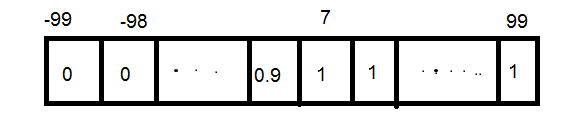


Answer was referred from the this [disscussion ](https://www.kaggle.com/c/nfl-big-data-bowl-2020/discussion/112375#latest-647367)

**How Cummulative distribution works??**

You might arrive at a question why from 7 that's what **cummulative distribution** is about!!

Cumulative distribution functions describe real random variables. Suppose that X is a random variable that takes as its values real numbers. Then the cumulative distribution function F for X is the function whose value at a real number x is the probability that X takes on a value less than or equal to x.


**F(x)=P(X≤x)**


Each c.d.f. F has the following four properties:

1. F is a nondecreasing function.
2. F is right continuous.
3. limx→∞F(x)=1.
4. limx→−∞F(x)=0.

## **Modelling**

In [ ]:
#y_train = df.loc[range(0, 509762, 22), "Yards"]

In [ ]:
#y_train.head(100)

In [ ]:
#y_train = np.zeros(shape=(df.shape[0], 199))
#for i,yard in enumerate(df['Yards'][::22]):
#    y_train[i, yard+99:] = np.ones(shape=(1, 100-yard))


In [ ]:
#y_train_ = np.array([df["Yards"][i] for i in range(0,509762,22)])
#data = [0 for i in range(199)]
#for y in y_train_:
#    data[int(y+99)]+=1
#plt.plot([i-99 for i in range(199)],data)

**This kernel is not completed yet stay tuned for updates**

Please **upvote ** the kernel if you find it useful